- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2024  
- **conda environment**: I used the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

# fMRI Data Organisation

An fMRI study typically involves multiple imaging protocols and subjects, resulting in complex datasets with numerous files in various formats, ranging from simple text files to multidimensional imaging data. These files can be organized in many ways, and without a consistent approach across projects and research groups, can arise in wasted time rearranging data or rewriting scripts to match specific file formats and structures, potentially introducing errors. Adopting a common standard for data organisation provides numerous advantages: it improves understanding of the data, even for those not directly involved in the project, reduces errors, enhances compatibility with analysis software, and facilitates the development of automated tools. In essence, it helps **make data FAIR** (Findable, Accessible, Interoperable, and Reusable).

The [Brain Imaging Data Structure (BIDS)](https://bids.neuroimaging.io/), developed since 2015, is a community-driven standard for organising data and metadata across various neuroscience modalities. Converting your fMRI project's data into BIDS format enables easier sharing, reuse, and application of automated pipelines and quality assurance protocols, such as [BIDS Apps](https://bids-apps.neuroimaging.io/) or your/your group's own pipelines.

Converting raw data into the BIDS format may initially appear challenging. While there are various conversion tools available (see a list [here](https://bids.neuroimaging.io/benefits#converters)), the range of options can make it hard to decide which tool to use. We have chosen [HeuDiConv](https://joss.theoj.org/papers/10.21105/joss.05839) which in fact predates the BIDS format and is a flexible, general-purpose converter for organising brain imaging data into structured directory layouts. 

In this tutorial, we will walk you through the process of converting fMRI data into BIDS format using HeuDiConv and show you how to interact with the resulting BIDS dataset using [PyBIDS](https://bids-standard.github.io/pybids/).

(*For a more detailed tutorial on BODS conversion see: [https://github.com/MRC-CBU/BIDS_conversion/tree/main/MRI](https://github.com/MRC-CBU/BIDS_conversion/tree/main/MRI).*)

Here are two recommended short videos to help you better understand the basics of fMRI terminology and data structure.

In [3]:
from IPython.display import display, HTML

display(HTML('''
<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3>fMRI Data Structure & Terminology (7 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/OuRdQJMU5ro" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3>Brain imaging data structure (11 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/5H6XaJLp2V8" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>
'''))

-----------

**Table of contents**    
1. Create a project folder   
2. Retrieving the DICOM files    
3. Converting to BIDS using HeuDiConv    
3.1. Step 1: Discovering your scans    
3.2. Step 2: Creating a heuristic file    
3.3. Step 3: Converting the data    
3.4. 'To Do' - additional information to check and add    
3.5. Validate BIDS structure    
4. PyBIDS    
4.1. Querying the BIDSLayout    
4.2. Filtering files by entities    
4.3. Filtering by metadata   
4.4. Other `return_type` values    
4.5. The `BIDSFile`   
4.6. `.tsv` files   
4.7. Filename parsing    
4.8. Report generation   

------------

## Create a project folder

There is no universally agreed standard, but here is a recommended folder structure for your fMRI project.

```bash
# ======================================================================
# Recommended directory structure for an fMRI project
# ======================================================================

# project_name                     
#    └── code
#        └── task
#        └── preprocessing
#        └── analysis
#    └── data
#    └── documents      # Protocols, reports, and other documentation
#    └── results        # Analysis results, figures, and summary outputs
#    └── scratch        # Temporary files and intermediate results
#    └── logs           # Log files, error reports, and processing records

```

You can create the folder structure manually or use a simple `command-line` command like this:
```bash
mkdir -p My_fMRI_study/{code/{task,preprocessing,analysis},data,documents,results,scratch,logs}
```

For this workshop, we have already created it for you as the `FaceProcessing` directory.

Let's take a look at the directory's current content.

In [ ]:
!tree FaceProcessing -L 2

## Retrieving the DICOM files

`DICOM` files are the raw imaging files generated by the MRI scanner. Typically, they are stored on an MRI data server. Here, at the CBU, each imaging project is assigned a unique code. By knowing the project's code, we can locate the raw DICOM files on our server.

For this tutorial, we have copied one subject's DICOM data from our server to the `mridata` directory.

In [ ]:
!tree mridata -L 3

Each `Series###` folder contains DICOM files of the particular scan. The name of the folder is the same as what a radiographer named the scan in the MRI console. Usually, the name is very indicative of what type of scan it is. In the example above, we acquired a T1w anatomical/structural scan (**MPRAGE**), nine functional scans (**BOLD**), and two **field maps**. The *Series_001_CBU_Localiser* scan is a positional scan for the MRI and can be ignored.

Each of these folders contains DICOM (`.dcm`) files, typically, one file per slice for structural scans or one file per volume for functional scans. These files contain a header with the metadata (e.g., acquisition parameters) and the actual image itself. DICOM is a standard format for any medical image, not just the brain. To work with the brain images, we **need to convert the DICOM files to NIfTI format** which is a cross-platform and cross-software standard for brain images. Along with having the files in NIfTI format, we need to **name and organise them according to BIDS** standard. For that, we will use HeuDiConv.

## Converting to BIDS using HeuDiConv

HeudiConv is a Python-based comand-line tool. To use it, you would either install *heudiconv* and *dcm2niix* packages locally (`pip install heudiconv dcm2niix`) or use Docker (or Apptainer/Singularity) container image (`docker pull nipy/heudiconv`).

Here we have *heudiconv* (and the required *dcm2niix*, for dicom to nifti conversion) included in the `mri` conda environment that we are using for this workshop. 

HeuDiConv does the following:

- converts DICOM (.dcm) files to NIfTI format (`.nii` or `.nii.gz`);
- generates their corresponding metadata files (`.json`);
- renames the files and organises them in folders following BIDS specification;
- generates several other `.json` and `.tsv` files required for BIDS datasets.

The final result of DICOM Series being converted into BIDS for our example subject above would be this:

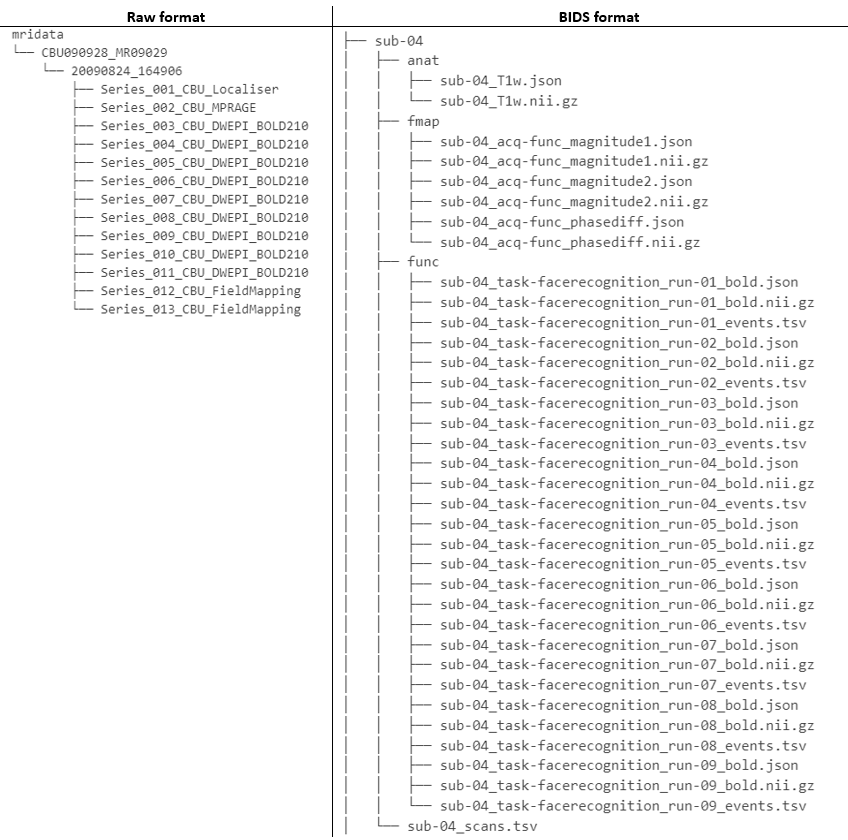

*(Why are we working with sub-04 instead of sub-01? The first three subjects in this study did not consent to having their raw data made public.)*

HeuDiConv needs information on how to translate your specific DICOMs into BIDS. This information is provided in a [heuristic file](https://heudiconv.readthedocs.io/en/latest/heuristics.html) that the user creates. To create the heuristic file, you need to know what scans you have, which ones you want to convert (you don't have to convert all scans, only the ones you need for your project), and how to uniquely identify each scan based on its metadata.

As such, **converting DICOM data to BIDS using HeuDiConv involves 3 main steps**:

 1. Discovering what DICOM series (scans) there are in your data
 2. Creating a heuristic file specifying how to translate the DICOMs into BIDS
 3. Converting the data

### Step 1: Discovering your scans

First, you need to know what scans there are in your MRI data and how to uniquely identify them using their metadata. While you could manually check the metadata of each DICOM file, this is not very convenient. Instead, you can 'ask' HeuDiConv to perform the scan discovery for you. By running HeuDiConv without specifying NIfTI conversion or a heuristic file, it will generate a DICOM info table that lists all scans and their metadata. It will look something like this:

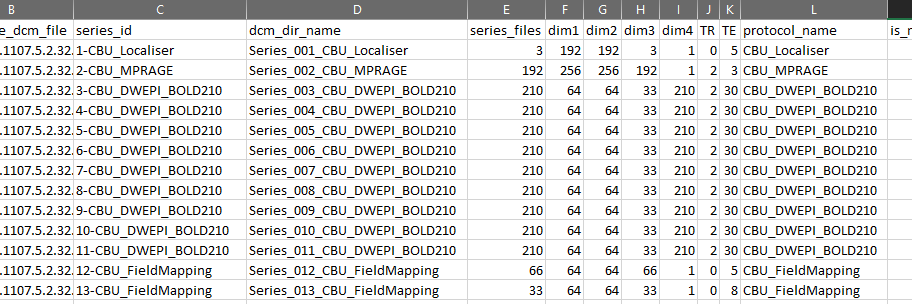

The column names are metadata fields and rows contain their corresponding values. To generate such a table, you would run the following command in the terminal:

`heudiconv --files mridata/CBU090928_MR09029/*/*/*.dcm --outdir FaceProcessing/scratch/dicom_discovery --heuristic convertall --subjects '04' --converter none --bids --overwrite`

However, command lines are error-prone and not easily reproducible. Instead, we recommend writing a simple bash script like this [code-examples/step01_dicom_discover.sh](code-examples/step01_dicom_discover.sh) 

**Example script:**

```bash
#!/bin/bash

# Path to the raw DICOM files
DICOM_PATH='/home/cognestic/COGNESTIC/05_fMRI/mridata/CBU090928_MR09029'

# Location of the output data (it will be created if it doesn't exist)
OUTPUT_PATH='/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/scratch/dicom_discovery'

# Subject ID
SUBJECT_ID='04'

# ------------------------------------------------------------
# Run the heudiconv
# ------------------------------------------------------------
heudiconv \
    --files "${DICOM_PATH}"/*/*/*.dcm \
    --outdir "${OUTPUT_PATH}" \
    --heuristic convertall \
    --subjects "${SUBJECT_ID}" \
    --converter none \
    --bids \
    --overwrite
# ------------------------------------------------------------

# Copy the dicominfo table outside the hidden directory
cp "${OUTPUT_PATH}"/.heudiconv/"${SUBJECT_ID}"/info/dicominfo.tsv "${OUTPUT_PATH}"

# ------------------------------------------------------------

# HeudiConv parameters:
# --files: Files or directories containing files to process
# --outdir: Output directory
# --heuristic: Name of a known heuristic or path to the Python script containing heuristic
# --subjects: Subject ID
# --converter : dicom to nii converter (dcm2niix or none)
# --bids: Flag for output into BIDS structure
# --overwrite: Flag to overwrite existing files
# 
# For a full list of parameters, see: https://heudiconv.readthedocs.io/en/latest/usage.html 

```

Let's run this script to discover which DICOMs our example subject has.

Normally, we would execute bash scripts from the terminal. However, we can also run command-line commands directly within the notebook by adding an '!' sign at the beginning. After running it, it's a good idea to comment it out to avoid accidentally running it again when it's not needed.

In [ ]:
#!./code-examples/step01_dicom_discover.sh

After running the script, the table that we are interested in will be located at *`OUTPUT_PATH/.heudiconv/[subject ID]/info/dicominfo.tsv`*. The .heudiconv directory is a hidden directory and you might not be able to see it in your file system unless you copy it to an unhidden directory which we in fact did (notice the last line in the script). 


Now, you can open the `dicominfo.tsv` file and keep it open for the next step - creating a heuristic file. 

### Step 2: Creating a heuristic file

The heuristic file must be a `Python` file. You can create and edit Python files in any text editor. You can name the file anything you want. For example, `bids_heuristic.py` like we have named our file which is available here: [code-examples/bids_heuristic.py](code-examples/bids_heuristic.py).

We need to specify the conversion template for each DICOM series. The template can be anything you want. In this particular case, we want it to be in BIDS format. Therefore for each of our scan types, we need to consult BIDS specification. A good starting point is to look at the BIDS starter kit [folders](https://bids-standard.github.io/bids-starter-kit/folders_and_files/folders.html) and [filenames](https://bids-standard.github.io/bids-starter-kit/folders_and_files/files.html). (See the full BIDS specification for MRI [here](https://bids-specification.readthedocs.io/en/stable/modality-specific-files/magnetic-resonance-imaging-data.html).)

Following these guidelines, we define the template (folder structure and filenames) for our anatomical, fieldmap, and functional scans. (We don't need to worry about the BIDS-required metadata, HeuDiConv will generate the required metadata for us.)

```python
    # The structural/anatomical scan
    anat = create_key('sub-{subject}/anat/sub-{subject}_T1w')
    
    # The fieldmap scans
    fmap_mag = create_key('sub-{subject}/fmap/sub-{subject}_acq-func_magnitude')
    fmap_phase = create_key('sub-{subject}/fmap/sub-{subject}_acq-func_phasediff')
    
    # The functional scans
    # You need to specify the task name in the filename. It must be a single string of letters WITHOUT spaces, underscores, or dashes!
    func_task = create_key('sub-{subject}/func/sub-{subject}_task-faceprocessing_run-{item:02d}_bold')
```

A couple of important points to note:

- For the fielmaps, we add a key-value pair `acq-func` to specify that these fieldmaps are intended for the functional images - to correct the functional images for susceptibility distortions. You will see how this key-value is relevant later.

- For the functional scans, you have to specify the task name. In our case, the task was *Face Processing*. The task name must be a **single string** of letters without spaces, underscores, or dashes!

- In this example project, we had multiple functional scans with identical parameters and task names. They correspond to multiple runs of our task. Therefore we add a `run` key and its value will be added automatically as a 2-digit integer (*run-01*, *run-02* etc.).

Next, we create a dictionary `info` with our template names as keys and empty lists for their values. The values will be filled in in the next step.

```python
    info = {
        anat: [],
        fmap_mag: [],
        fmap_phase: [],
        func_task: []
        }
```
A `for loop` loops through all our DICOM series that are found in the `RAW_PATH` that we specify in our HeuDiConv parameters. Here we need to specify the criteria for associating DICOM series with their respective outputs. Now you need to look at the *dicominfo.tsv* table that we generated in the previous step.

- We only have one DICOM series with *MPRAGE* in its protocol name. Therefore for the anatomical scan, we don't need to specify any additional cireteria.

- We have two fieldmaps. One of them should be a *magnitude* image and the other one a *phase* image. Both have *FieldMapping* in their protocol name therefore we need to define additional criteria to distinguish between them. They differ in the `dim3` parameter. If in doubt, ask your radiographer, but typically, the *magnitude* image has more slices (higher `dim3`).

- Our 9 functional scans are the only ones with more than one volume (`dim4`). They all are different runs of the same task, therefore we don't need any other distinguishing criteria for them, just the `dim4`. We specify here `dim4 > 100` because it could happen that not all participants and not all runs had exactly 210 volumes collected. In addition, sometimes it happens that a run is cancelled due to some problem and we want to discard any run with less than 100 volumes.

```python
# Loop through all the DICOM series and assign them to the appropriate conversion key.
    for s in seqinfo:
        # Uniquelly identify each series
        
        # Structural
        if "MPRAGE" in s.series_id:
            info[anat].append(s.series_id)
            
        # Field map Magnitude (the fieldmap with the largest dim3 is the magnitude, the other is the phase)
        if 'FieldMapping' in s.series_id and s.series_files == 66:
            info[fmap_mag].append(s.series_id)
            
        # Field map PhaseDiff
        if 'FieldMapping' in s.series_id and s.series_files == 33:
            info[fmap_phase].append(s.series_id)

        # Functional Bold
        if s.dim4 > 100:
           info[func_task].append(s.series_id)
            
    # Return the dictionary
    return info
```
Finally, we add `POPULATE_INTENDED_FOR_OPTS` dictionary to our heuristic file. This will automatically add an `IntendedFor` field in the fieldmap .json files telling for which images the fieldmaps should be used to correct for susceptibility distortion. Typically, these are the functional images. There are several options how you can specify for which images the fieldmaps are intended for. See full information [here](https://heudiconv.readthedocs.io/en/latest/heuristics.html#populate-intended-for-opts). In our example, we specify to look for a `modality acquisition label`. It checks for what modality (e.g., *anat*, *func*, *dwi*) each fieldmap is intended by checking the `acq-` label in the fieldmap filename and finding corresponding modalities. For example, `acq-func` will be matched with the `func` modality. That's why when defining the template for the `fmap_mag` and `fmap_phase` we added `acq-func` in their filenames.

```python
POPULATE_INTENDED_FOR_OPTS = {
    'matching_parameters': ['ModalityAcquisitionLabel'],
    'criterion': 'Closest'
}
```

Other, more advanced functions can be added to the heuristic file as well, such as input file filtering. For full information, see the [documentation](https://heudiconv.readthedocs.io/en/latest/heuristics.html).

### Step 3: Converting the data

Once our heuristic file is created, we are ready to convert our raw DICOM data to BIDS.

To do that, we need to make three changes in our *code-examples/step01_dicom_discover.sh* bash script that we wrote in the first step. We named the edited script [code-examples/step02_dicom_to_bids.sh](code-examples/step02_dicom_to_bids.sh).

- We need to change the output path because we don't want to put this result in the *scratch* directory but in the final *data* directory

- We need to change the `--heuristic` parameter specifying the path to our newly created heuristic file

- We need to change the `--converter` parameter to `dcm2niix` because now we want the DICOM files to be converted to NIfTI format.

Once these changes are saved, you can run the script from the terminal:


`./code-examples/step02_dicom_to_bids.sh`


In [ ]:
#!./code-examples/step02_dicom_to_bids.sh

### 'To Do' - additional information to check and add

Once you have converted the DICOMs to BIDS, there are some details you'll need to fill in yourself to ensure the dataset is fully BIDS-compliant. HeuDiConv marks any 'missing' information with `'To Do'` placeholders.

#### Events

HeuDiConv generates the `events.tsv` file for each functional run. The files are just a template that you need to fill with the actual data. 

In [ ]:
import pandas as pd

events_file_empty = pd.read_csv('FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-01_events.tsv', sep='\t')
events_file_empty .head()


For functional images, if they are not resting-state scans but involve participants performing a task, you will need to provide details such as *trial type*, *onset*, and *duration*. This data should come from the outputs of your experimental script, so make sure your task is programmed in a way that allows you to easily retrieve the necessary trial and timing information.

**For our example subject, we have prepared the final events files, and you will need to copy them into the subject's 'func' folder.** 

In [ ]:
# copy the prepared events
!rm -f FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-*.tsv
!cp -r sub-04_task-files/* FaceProcessing/data/sub-04/func

In [ ]:
events_file_filled = pd.read_csv('FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-01_events.tsv', sep='\t')

events_file_filled.head()

If you are interested how we obtained the events information from the OpenNeuro dataset, have a look at these two scripts: [code-examples/step03_events_to_bids.py](code-examples/step03_events_to_bids.py) and [code-examples/step04_transform_events.py](code-examples/step04_transform_events.py)

#### Dataset description

`dataset_description.json`

A brief description of your dataset. 

```json
{
  "Acknowledgements": "TODO: whom you want to acknowledge",
  "Authors": [
    "TODO:",
    "First1 Last1",
    "First2 Last2",
    "..."
  ],
  "BIDSVersion": "1.8.0",
  "DatasetDOI": "TODO: eventually a DOI for the dataset",
  "Funding": [
    "TODO",
    "GRANT #1",
    "GRANT #2"
  ],
  "HowToAcknowledge": "TODO: describe how to acknowledge -- either cite a corresponding paper, or just in acknowledgement section",
  "License": "TODO: choose a license, e.g. PDDL (http://opendatacommons.org/licenses/pddl/)",
  "Name": "TODO: name of the dataset",
  "ReferencesAndLinks": [
    "TODO",
    "List of papers or websites"
  ]
}
```

#### Participants

`participants.json`

```json
{
  "participant_id": {
    "Description": "Participant identifier"
  },
  "age": {
    "Description": "Age in years (TODO - verify) as in the initial session, might not be correct for other sessions"
  },
  "sex": {
    "Description": "self-rated by participant, M for male/F for female (TODO: verify)"
  },
  "group": {
    "Description": "(TODO: adjust - by default everyone is in control group)"
  }
}
```

#### Task information

`task-facerecognition_bold.json`

Could add full task name and a Cognitive Atlas ID if it exists. 
```json
{
 ...
  "TaskName": "TODO: full task name for facerecognition",
 ...
 ```

#### README

*"TODO: Provide description for the dataset -- basic details about the study, possibly pointing to pre-registration (if public or embargoed)"*

See an example for the OpenNeuro version of this dataset https://openneuro.org/datasets/ds000117/versions/1.0.5/file-display/README

### Validate BIDS structure

Once we have our BIDS dataset, we can use an [online BIDS validator](https://bids-standard.github.io/bids-validator/) to check if our dataset confirms with BIDS standard and what additional information we might need to include in your dataset's metadata. 

## PyBIDS

`PyBids` is a Python module to interface with datasets conforming BIDS. See the [documentation](https://bids-standard.github.io/pybids/) and [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7409983/) for more info. 

**Let's explore some of the functionality of pybids.layout.** The material is adapted from https://github.com/bids-standard/pybids/tree/master/examples

In [ ]:
from bids.layout import BIDSLayout

fmri_data_dir = 'FaceProcessing/data'

# Initialize the layout
layout = BIDSLayout(fmri_data_dir)

# Print some basic information about the layout
layout

### Querying the BIDSLayout
The main method for querying `BIDSLayout` is `.get()`.

If we call `.get()` with no additional arguments, we get back a list of all the BIDS files in our dataset.

In [ ]:
all_files = layout.get()
print("There are {} files in the layout.".format(len(all_files)))
print("\nThe first 5 files are:")
all_files[:5]

The returned object is a list of `BIDSFile` objects. 

We can also get just filenames.

In [ ]:
layout.get(return_type='filename')[:5]

We can also get such information as
* all `subject` IDs
* all `task` names
* dataset `description`
* the BOLD repetition time TR
* how many `runs` there are

In [ ]:
layout.get_subjects()

In [ ]:
layout.get_tasks()

In [ ]:
layout.get_dataset_description()

In [ ]:
layout.get_tr()

Regarding runs, it might be that there are varied number of runs accross participants. So, let's get runs for each participant. 

In [ ]:
for sID in layout.get_subjects(): 
    print(layout.get_runs(subject = sID))

### Filtering files by entities
We can pass any BIDS-defined entities (keywords) to `.get()` method. For example, here's how we would retrieve all BOLD runs with `.nii.gz` extensions for subject `04`.

In [ ]:
# Retrieve filenames of all BOLD runs for subject
layout.get(subject='04', extension='nii.gz', suffix='bold', return_type='filename')

All of the entities are found in the names of BIDS files. For example `sub-01_task-facerecognition_run-01_bold.nii.gz` has entities: **subject**, **task**, **run**, **suffix**, **extension**.

You can get the list of all availabe entities by `layout.get_entities()`.

Here are a few of the most common entities:

* `suffix`: The part of a BIDS filename just before the extension (e.g., 'bold', 'events', 'T1w', etc.).
* `subject`: The subject label
* `session`: The session label
* `run`: The run index
* `task`: The task name

### Filtering by metadata
Sometimes we want to search for files not just by their names, but also based on metadata defined in JSON files. We can use any key that appears in a JSON file in our project as an argument to `.get()`. This can be combined with any number of core BIDS entities (like *subject*, *run*, etc.).

For example, let's retrieve the subject's `SpacingBetweenSlices` (measured from the center of each slice to the next, in mm).

In [ ]:
layout.get_SpacingBetweenSlices(subject='04', suffix='bold')

**==================================================================================================**

**EXCERCISE**

We want to know the time of the day when the subject was scanned. The scanning started with T1 images, so we want to retrieve the `AcquisitionTime` of subject's `T1w` image. Adapt the script above to acquire this information. 


In [ ]:
# write your code here

**==================================================================================================**

### Other `return_type` values
We can also ask `get()` to return unique values (or IDs) of particular entities. For example, we want to know which subjects had a fieldmap acquired. We can request that information by setting `return_type='id'` - to get subject IDs. When using this option, we also need to specify a `target` entity for the ID (in this case, subject). This combination tells the `BIDSLayout` to return the unique values for the specified `target` entity. 

For example, in the next example, we ask for all of the unique subject IDs that have at least one file with a `phasediff` (fieldmap) suffix. 

In [ ]:
# Ask get() to return the ids of subjects that have phasediff (fieldmap_ files)

layout.get(return_type='id', target='subject', suffix='phasediff')

If our `target` is a BIDS entity that corresponds to a particular directory in the BIDS specification (e.g., `subject` or `session`) we can also use `return_type='dir'` to get all matching subdirectories. 

In [ ]:
layout.get(return_type='dir', target='subject')

### The `BIDSFile`
When you call `.get()` on a `BIDSLayout`, the default returned values are objects of class `BIDSFile`. A `BIDSFile` is a lightweight container for individual files in a BIDS dataset. It provides easy access to a variety of useful attributes and methods. Let's take a closer look. First, let's pick a random file from our existing `layout`.

In [ ]:
# Pick the 7th file in the dataset
bf = layout.get(subject='04', extension='nii.gz', suffix='bold')[0]
# Print it
bf

Here are some of the attributes and methods available to us in a `BIDSFile` (note that some of these are only available for certain subclasses of `BIDSFile`; e.g., you can't call `get_image()` on a `BIDSFile` that doesn't correspond to an image file!):
* `.path`: The full path of the associated file
* `.filename`: The associated file's filename (without directory)
* `.dirname`: The directory containing the file
* `.get_entities()`: Returns information about entities associated with this `BIDSFile` (optionally including metadata)
* `.get_image()`: Returns the file contents as a nibabel image (only works for image files)
* `.get_df()`: Get file contents as a pandas DataFrame (only works for TSV files)
* `.get_metadata()`: Returns a dictionary of all metadata found in associated JSON files
* `.get_associations()`: Returns a list of all files associated with this one in some way

Let's see some of these in action.

In [ ]:
# Print all the entities associated with this file, and their values
bf.get_entities()

In [ ]:
# Print first 30 metadata items associated with this file
file_metadata = bf.get_metadata()

{k: file_metadata[k] for k in list(file_metadata)[:30]}

`.get_image()`: Returns the file contents as a `nibabel` image (only works for image files). We can then display the image, for example, using `OrthoSlicer3D`.   

**Note:** When using `orthoview()` in notebook, don't forget to close figures afterward again or use %matplotlib inline again, otherwise, you cannot plot any other figures.

In [ ]:
%matplotlib inline

bf.get_image().orthoview()

### `.tsv` files

In cases where a file has a `.tsv.gz` or `.tsv` extension, it will automatically be created as a `BIDSDataFile`, and we can easily grab the contents as a `DataFrame`.

Let's look at the first `events` file from our layout.

In [ ]:
# Get the first events file
evfile = layout.get(suffix='events')[0]

# Get contents as a DataFrame and show the first few rows
df = evfile.get_df()
df.head()

Let's look at the `participants` information. 

In [ ]:
participants = layout.get(suffix='participants', extension='tsv')[0]

df = participants.get_df()
df.sort_values(by=['participant_id'])

### Filename parsing
Let’s say you have a filename and want to manually extract BIDS entities from it. . The `parse_file_entities` method provides the facility:

In [ ]:
layout.parse_file_entities('some_path_to_bids_file/sub-04_task-facerecognition_run-01_bold.nii.gz')

You can do the same for `BIDSFile` object that we defined earlier. 

In [ ]:
layout.parse_file_entities(bf.path)

In [ ]:
layout.parse_file_entities(bf.filename)

### Report generation
`PyBIDS` also allows you to automatically create data acquisition reports based on the available `image` and `meta-data` information. This enables a new level of standardisation and transparency. FAIR-ness, meta-analyses, etc. 

In [ ]:
# import the BIDSReport function from the reports submodule
from bids.reports import BIDSReport

Now we only need to apply the `BIDSReport` function to our `layout` and generate our report. 

In [ ]:
# Initialize a report for the dataset
report = BIDSReport(layout)

# Method generate returns a Counter of unique descriptions across subjects
try:
    descriptions = report.generate()
    pub_description = descriptions.most_common()[0][0]
    print(pub_description)
except IndexError:
    print('Sorry, it seems that the dataset is not complete and report cannot be generated.')